# APPM X720 Biweekly Report

### *Alexey Yermakov*
### *March 15, 2022*

# Summary

In this report I explore Byte Pair Encoding (BPE) on the newstest2013 dataset. I also do a brief EDA on newstest2013 since I have not heard of this dataset before.

# Main Content

*Note*: For some reason, all of my usual methods of adding in-place images to this notebook were failing. I was unable to figure out what was causing this issue so please refer to the images as they're discussed. I apologize for any inconvenience!

### **Byte Pair Encoding**

First, I explore Byte Pair Encoding (BPE). The paper which references this method from class can be found [here](https://arxiv.org/pdf/1508.07909.pdf). The paper uses this method in neural machine translation so that the meaning of unknown words can be inferred from "smaller units" that make up the word. For example, if the word "sweetish" is unknown during translation time, then we can imagine that the sub-words "sweet" and "ish" have been found during training time which can allow the model to infer what "sweetish" means.

Fortunately, the aforementioned paper provides the algorithm used for BPE! Here it is:

<img src="Images/Algorithm.png" alt="BPE Algorithm" style="width:500px">
(Please refer to `Images/Algorithm.png`)

What does this do? First, our vocab is split into individual characters, as well as a special "end of word" character denoted by `</w>`. The characters are separated by spaces in this example. The vocab also contains frequencies of each word (look at the `vocab` variable above). Then, we run the BPE algorithm `num_merges` number of times to combine the most frequent pairs of tokens (which are initially just characters, but later include groups of characters). After `num_merges` iterations, we have a *new* vocab which contains groupings of characters which are potentially full words, sub-words, or individual characters of out original vocabulary.

Lets now implement this in Python 3 and test it out.

First I have my usual imports.

In [1]:
# Make sure PyTorch is installed and our GPU is available
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import re, collections
from tabulate import tabulate
import os

# Check if GPU is available
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


Then, I define the algorithm by copying the pseudo-code from above. I modified the for loop over `num_merges` to make the output of the code cleaner in the notebook. I did not modify `get_stats` nor `merge_vocab`.

In [2]:
# Copied from pseudocode
def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs
    
# Copied from pseudocode
def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

# Modified from Pseudocode
def run_BPE_example(vocab, num_merges = 10, verbose=1):
    # Iterate over number of merges
    for i in range(num_merges):
        # Get pairs and their frequencies
        pairs = get_stats(vocab)
        
        # Get the most frequent pair, sometimes this fails if
        # there are no more pairs (all words are whole)
        try:
            best = max(pairs, key=pairs.get)
        except:
            raise Exception(f"run_BPE_example: max() failed for merge number {i+1}")
            
        # Merge the vocab together based on the most frequent pair
        vocab = merge_vocab(best, vocab)
        
        # Prints
        if verbose == 1:
            print(best)
            print(vocab)
            print()
        elif verbose == 2:
            print(best)
            print()
    
    # Return merged vocab
    return vocab
    
sample_dict = {'l o w </w>':5, 'l o w e r </w>':2, 'n e w e s t </w>':6, 'w i d e s t </w>':3}
run_BPE_example(vocab = sample_dict, verbose=1, num_merges=10)
None

('e', 's')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}

('es', 't')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}

('est', '</w>')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}

('l', 'o')
{'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}

('lo', 'w')
{'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}

('n', 'e')
{'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}

('ne', 'w')
{'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}

('new', 'est</w>')
{'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}

('low', '</w>')
{'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}

('w', 'i')
{'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}



Excellent! The code works fine in Python 3 and we get the same output as we saw in the [lecture slide](https://raw.githubusercontent.com/maziarraissi/Applied-Deep-Learning/main/02%20-%20Natural%20Language%20Processing/03%20-%20Neural%20Machine%20Translation.pdf):

<img src="Images/Lecture.png" alt="Lecture Slide" style="width:500px">
(Please refer to `Images/Lecture.png`)

This is fine and dandy, but I want some helper functions that take in a sentence, or a list of sentences, and turns it into a vocabulary we can input into the BPE algorithm above. This will help working with a real dataset much easier.

In [3]:
# Given a list of lines, get the vocab and frequency for each word
def create_vocab_from_lines(lines):
    vocab = {}
    for line in lines:
        words = line.split(' ')
        for word in words:
            vocab[word] = vocab.get(word, 0) + 1
    return vocab

print(create_vocab_from_lines(["help me make", "this function",\
                    "or don't help me", "and watch me cry"]))

{'help': 2, 'me': 3, 'make': 1, 'this': 1, 'function': 1, 'or': 1, "don't": 1, 'and': 1, 'watch': 1, 'cry': 1}


That was easy enough! Now I want a function which takes the output of the BPE algorithm above and turns it into a vocabulary like what we have in the preceding code block.

In [4]:
# Given a BPE output from the pseudocode, convert it back to a vocab with frequencies
def create_vocab_from_BPE(BPE_output):
    vocab = {}
    for key, item in BPE_output.items():
        tokens = key.split(' ')
        for token in tokens:
            vocab[token] = vocab.get(token, 0) + item
    return vocab

print(create_vocab_from_BPE(run_BPE_example(sample_dict, verbose=0)))

{'low</w>': 5, 'low': 2, 'e': 2, 'r': 2, '</w>': 2, 'newest</w>': 6, 'wi': 3, 'd': 3, 'est</w>': 3}


Great! So this looks like it works too, though the keen-eye among you will notice that this doesn't really prove that the case where there is the same token in multiple outputs of the BPE algorithm, then the frequency adds up. For example, if the input dictionary was:

`{'low </w>': 5, '</w>': 2}`

then the output of the above function would be:

`{'low': 5, '</w>': 7}`

Fortunately, this is really easy to test!

In [5]:
print(create_vocab_from_BPE({'low </w>': 5, '</w>': 2}))

{'low': 5, '</w>': 7}


Excellent! One last thing I want is to convert a sample dictionary into something that BPE can work with.

In [6]:
# Given a vocab of frequencies, convert it to BPE-pseudocode accepted input
def create_BPE_from_vocab(vocab):
    output = {}
    for key, value in vocab.items():
        output[" ".join(key) + " </w>"] = value
    return output
    
sample_dict = {"low": 5, "lower": 2, "newest": 6, "wildest": 3}
print("Original dict:", sample_dict)
output_dict = create_BPE_from_vocab(sample_dict)
print("Output dict:", output_dict)
print("Re-run BPE:")
run_BPE_example(vocab = output_dict, verbose=1)

Original dict: {'low': 5, 'lower': 2, 'newest': 6, 'wildest': 3}
Output dict: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i l d e s t </w>': 3}
Re-run BPE:
('e', 's')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i l d es t </w>': 3}

('es', 't')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i l d est </w>': 3}

('est', '</w>')
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i l d est</w>': 3}

('l', 'o')
{'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i l d est</w>': 3}

('lo', 'w')
{'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i l d est</w>': 3}

('n', 'e')
{'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i l d est</w>': 3}

('ne', 'w')
{'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i l d est</w>': 3}

('new', 'est</w>')
{'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i l d est</w>': 3}

('low', '</w>')
{'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i l d est</

{'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi l d est</w>': 3}

Very good! Now we can run some tests on a dataset and see our results. The [paper](https://arxiv.org/pdf/1508.07909.pdf) mentions the `newstest2013` dataset (see Table 1's description). I went ahead and downloaded the dataset from [here](https://nlp.stanford.edu/projects/nmt/data/wmt15.en-cs/newstest2013.en). I'll now do a quick EDA detour for that dataset.

### **Newstest 2013 EDA**

Where does this dataset come from? Unfortunately, after googling for a while, I was unable to locate its source. However, I think I have a good understanding of what it's used for. The file contains 3000 lines of sentences in english. There are accompanying datasets which are translations of the English file (for example, in German and Czech). These can be found [here](https://nlp.stanford.edu/projects/nmt/).

What is this dataset used for? Due to the aforementioned translated versions, these files are used to test translation models! Though, you may also be surprised at how little number of sentences there are. However, this can be explained by the fact that it is not used to train the models, but to evaluate their performance! The link in the previous paragraph has training files which contain several *millions* of lines of data for training, which is much better for deep learning applications.

Now lets look deeper at `newstest2013.en` - the English translation. First, I define a function which gets the frequencies of words from the original dataset. I also print the number of sentences and words.

In [7]:
# Location of dataset
top_dir = "/home/alexey/School/APPM 4720/Biweekly/Mar15/Report/Datasets"
newstest2013 = os.path.join(top_dir, 'newstest2013.en')

# Returns an ordered dictionary of words and their frequencies
def get_freq_data(file_name):
    # Output vocab
    words_dict = OrderedDict()
    
    # Total number of sentences
    num_sentences = 0
    
    # Open file
    with open(file_name) as f:
        # Read line by line
        lines = f.readlines()
        num_sentences = len(lines)
        for i in range(len(lines)):
            line = lines[i]
            words = line.split()
            
            # Split each line into words
            for word in words:
                # Add and/or increment relevant frequency for the word
                words_dict[word] = words_dict.get(word, 0) + 1

        # Sort dictionarie
        words_dict = OrderedDict(sorted(words_dict.items(), key=lambda x: x[1], reverse=True))

        # Return dictionary and the number of sentences
        return words_dict, num_sentences
    raise Exception("get_data: File cound not be opened")
    
words_freq_dict, num_sentences = get_freq_data(newstest2013)

print("Number of sentences:", num_sentences)
print("Number of words:", len(words_freq_dict))

Number of sentences: 3000
Number of words: 9676


Now, we can display some meaningful figures and statistics! First, I make a table of the 20 most and least common words from the dataset.

In [8]:
# Take a vocab with frequencies and make it a pretty table
def make_freq_table(words_freq_dict):
    # Parameters
    cur_dict = words_freq_dict
    dict_title = "Word"
    n = 20
    
    # Create our table data
    dict_tmp = dict()
    dict_tmp[dict_title] = list()
    dict_tmp["Count"] = list()
    dict_len = len(cur_dict)
    for k in cur_dict:
        dict_tmp[dict_title].append(k)
        dict_tmp["Count"].append(cur_dict[k])

    # Shrink our output if there are too many items
    if len(dict_tmp[dict_title]) > 2*n:
        dict_tmp[dict_title] = dict_tmp[dict_title][0:n] + ["..."] + dict_tmp[dict_title][-n:]
        dict_tmp["Count"] = dict_tmp["Count"][0:n] + ["..."] + dict_tmp["Count"][-n:]

    print(tabulate(dict_tmp, headers="keys", tablefmt="pretty"))
    return None
    
make_freq_table(words_freq_dict)

+------------------+-------+
|       Word       | Count |
+------------------+-------+
|        ,         | 3719  |
|       the        | 3442  |
|        .         | 2710  |
|        of        | 1780  |
|        to        | 1477  |
|        in        | 1211  |
|       and        | 1198  |
|        a         | 1197  |
|        "         | 1004  |
|        is        |  842  |
|       that       |  586  |
|       for        |  490  |
|       are        |  430  |
|       The        |  422  |
|        on        |  401  |
|       with       |  399  |
|        it        |  387  |
|        I         |  366  |
|       not        |  350  |
|        be        |  323  |
|       ...        |  ...  |
|      Zeglen      |   1   |
|   21-year-old    |   1   |
|     Chester      |   1   |
|      Mayans      |   1   |
|     suffers      |   1   |
|     anxiety      |   1   |
|    predicting    |   1   |
|   speculations   |   1   |
| English-speaking |   1   |
|    Dougherty     |   1   |
|      Salle  

Cool! Keep in mind that this dataset is pre-processed, so a sentence starting with `"The ...` would be split into a sentence like `" The ...`, which is why `"` is seen as a very frequent word. On first observation, this data isn't super interesting, since we see frequent words at the top and less frequent words at the bottom. Lets see what the distribution of words look like.

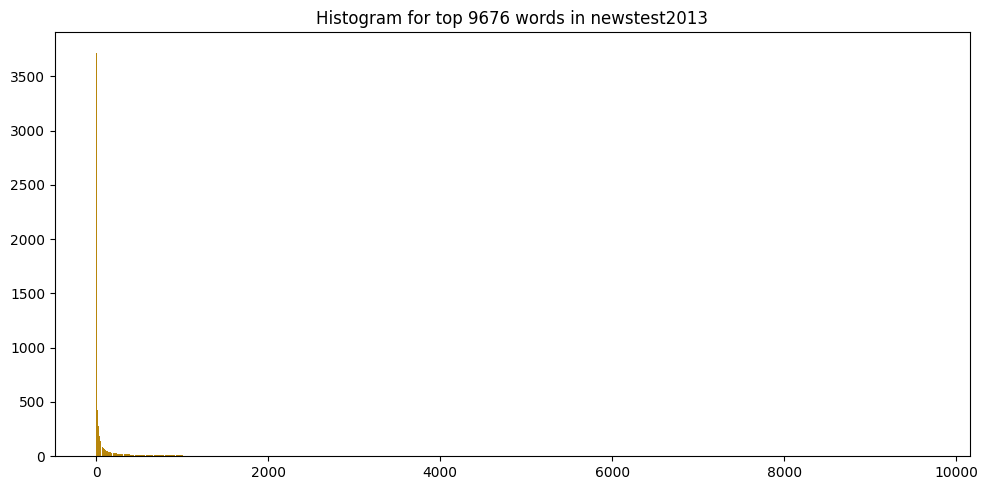

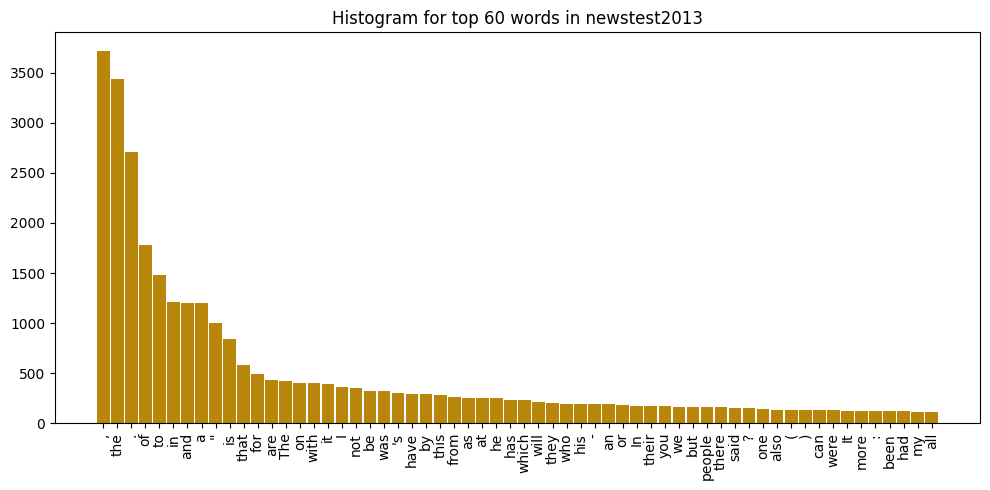

In [9]:
# Given a vocab of frequencies, make a nice histogram
def make_freq_histogram(words_freq_dict, num_lines, n_top = 10, labels=True):
    # Plot handles
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    # Convert names of variables since this is re-used code from a previous report
    cur_dict, dict_title = words_freq_dict, "Words"
    
    # Create our plotting data
    dict_tmp = dict()
    dict_tmp[dict_title] = list()
    dict_tmp["Count"] = list()
    dict_len = len(cur_dict)
    for k in cur_dict:
        dict_tmp[dict_title].append(k)
        dict_tmp["Count"].append(cur_dict[k])

    # Shrink our output if there are too many items
    if len(dict_tmp[dict_title]) > 2*n_top:
        dict_tmp[dict_title] = dict_tmp[dict_title][0:n_top]
        dict_tmp["Count"] = dict_tmp["Count"][0:n_top]

    # Change the naming
    keys = dict_tmp[dict_title]
    values = dict_tmp["Count"]

    # Make the histogram
    ax.bar(range(len(keys)), values, 0.9, color='darkgoldenrod')
    ax.set_title(f"Histogram for top {n_top} {dict_title.lower()} in newstest2013")
    if labels:
        ax.set_xticks(range(len(keys)), keys, rotation='vertical')
    
    fig.tight_layout()

make_freq_histogram(words_freq_dict, num_sentences, n_top = len(words_freq_dict), labels=False)
make_freq_histogram(words_freq_dict, num_sentences, n_top = 60, labels=True)

So, from the above figures we can see that there is a strong presence of a very *small* amount of high-frequency words and a *long* tail of much less frequent words. I would expect this with language datasets and this doesn't seem to striking to me. Anyways, back to BPE!

### **Byte Pair Encoding (Continued)**

A big benefit of BPE is that it only marginally increases the number of tokens in a corpus while *significantly* reducing the number of types of a corpus. We can refer to the following table to see this from the paper we covered in class:

<img src="Images/BPETable.png" alt="BPE Table" style="width:500px">
(Please refer to `Images/BPETable.png`)

In this context, a token is a single vocabulary word and a type is a unique vocabulary word. So, for the sentence "Where in the world did the cat in the cat go" the sentence length is 11, which is the number of tokens, and the number of types is the number of unique words, which is "8". 

Lets add one more function that will help us calculate these values from a dictionary of words and frequencies.

In [10]:
# Given a dictionary of frequencies, return the number of tokens and types
def get_num_tokens_types(input_dict):
    num_tokens = 0
    num_types = len(input_dict)
    for _, value in input_dict.items():
        num_tokens += value
    return num_tokens, num_types

print("Sample dictionary:", sample_dict)
tokens, types = get_num_tokens_types(sample_dict)
print(f"Tokens: {tokens}, types: {types}")

Sample dictionary: {'low': 5, 'lower': 2, 'newest': 6, 'wildest': 3}
Tokens: 16, types: 4


Now let's explore the effect of BPE on these values! lets get a baseline reading first, by calculating tokens and types for the newstest2013 dataset without any BPE.

In [11]:
words_freq_dict, num_sentences = get_freq_data(newstest2013)
tokens, types = get_num_tokens_types(words_freq_dict)
print(f"Tokens: {tokens}, types: {types}")

Tokens: 64807, types: 9676


Let's now use BPE with 10 merging steps and see how this affects our data.

In [12]:
# Given a vocab, return the number of tokens and types after some amount of merges
def newstest2013_BPE(vocab, num_merges = 10, verbose = 0):
    original_dict = vocab # expecting newstest2013 dictionary of words and frequencies
    tokens, types = get_num_tokens_types(original_dict) # Input tokens and types number
    print(f"Original #tokens: {tokens}, #types: {types}\n")

    # Convert newstest2013 dictionary to BPE input formatted
    # (spaces between characters and </w> at the end of each word)
    BPE_formatted_dict = create_BPE_from_vocab(original_dict)
  
    # Optional print
    if verbose != 0:
        print("BPE merges:")
    
    # Run BPE
    BPE_output_dict = run_BPE_example(vocab = BPE_formatted_dict, num_merges = num_merges, verbose=verbose)

    # Convert BPE into a vocab dictionary of frequencies
    post_BPE_vocab_dict = create_vocab_from_BPE(BPE_output_dict)

    # Get number of tokens and types
    tokens, types = get_num_tokens_types(post_BPE_vocab_dict)
    print(f"BPE #tokens: {tokens}, #types: {types}\n")
    return None

newstest2013_BPE(words_freq_dict, num_merges = 10, verbose = 2)

Original #tokens: 64807, #types: 9676

BPE merges:
('e', '</w>')

('s', '</w>')

('t', 'h')

('n', '</w>')

('t', '</w>')

('d', '</w>')

('e', 'r')

(',', '</w>')

('th', 'e</w>')

('y', '</w>')

BPE #tokens: 286038, #types: 102



Great! So with 10 merges we can start to intuit about why the number of types goes down: we are effectively starting with a uni-gram representation of our data and merging our uni-grams into larger n-grams. The number of tokens in my above case is extremely large, since we're splitting our original words into individual characters. The [paper](https://arxiv.org/pdf/1508.07909.pdf) uses 59,500 merges for their model (they use 89,500 for joint BPE but I don't cover that in this report). Let's see what happens then:

In [13]:
# Wrap the previous function in a try-except so we don't actually get an error
try:
    # Spoiler! This will fail.
    newstest2013_BPE(words_freq_dict, num_merges = 59500, verbose = 0)
except Exception as e:
    print("Error!")
    print(e)

Original #tokens: 64807, #types: 9676

Error!
run_BPE_example: max() failed for merge number 16876


Unfortunately, after 16,875 merges the BPE code fails. This is because there are no other words left to merge! To verify this, lets run this again with `num_merges=16875` and see what we have:

In [14]:
newstest2013_BPE(words_freq_dict, num_merges = 16875, verbose = 0)

Original #tokens: 64807, #types: 9676

BPE #tokens: 64807, #types: 9676



Great! This is what we'd expect if we just merged all of our words back into whole words. I'm not sure why the paper mentions 59,500 merge operations, since we can clearly see that it breaks BPE. They might be talking about using BPE on another dataset. If anyone knows the answer please let me know!

Let's try again with a few different values and analyze the results.

In [15]:
for merges in [5000, 10000, 15000]:
    print(f"Running BPE for {merges} merges:")
    newstest2013_BPE(words_freq_dict, num_merges = merges, verbose = 0)
    print("---------------------------------")

Running BPE for 5000 merges:
Original #tokens: 64807, #types: 9676

BPE #tokens: 82585, #types: 4691

---------------------------------
Running BPE for 10000 merges:
Original #tokens: 64807, #types: 9676

BPE #tokens: 71682, #types: 8148

---------------------------------
Running BPE for 15000 merges:
Original #tokens: 64807, #types: 9676

BPE #tokens: 66682, #types: 9884

---------------------------------


Very nice! So from the above output we can see that as the number of merges approaches 16875, the number of tokens and number of types approach that of the non-BPE vocabulary. As mentioned earlier, BPE can  be used to reduce the number of types significantly while only marginally increasing the number of tokens. We can see this result with 5,000 merges, where the number of tokens increased 27% but the number of types decreased more than 50%! I now want to see what this looks like on a plot, but need to modify my functions slightly to get the data.

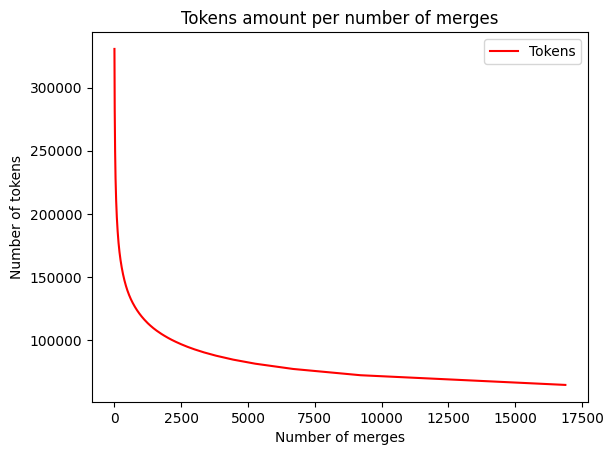

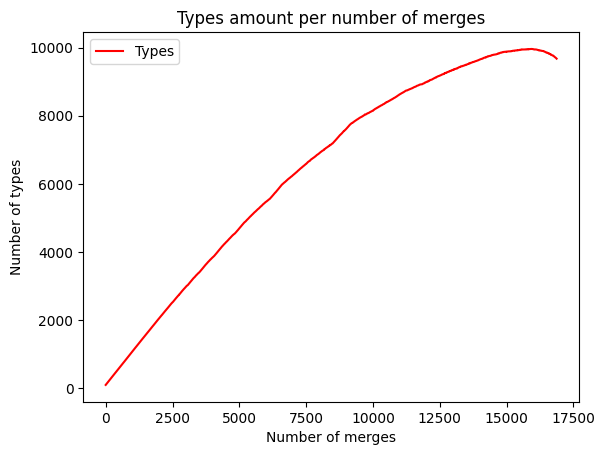

In [16]:
# Given a BPE formatted vocab, get the number of tokens and types for each time we merge via BPE
def get_BPE_data(vocab, num_merges = 10):
    # New: Store data
    tokens_list = []
    types_list = []
    
    # Iterate over num_merges
    for i in range(num_merges):
        pairs = get_stats(vocab)
        try:
            best = max(pairs, key=pairs.get)
        except:
            raise Exception(f"run_BPE_example: max() failed for merge number {i+1}")
        vocab = merge_vocab(best, vocab)
        
        # New: convert back vocab to get tokens and types
        post_BPE_vocab_dict = create_vocab_from_BPE(vocab)
        tokens, types = get_num_tokens_types(post_BPE_vocab_dict)
        
        # New: Append to list
        tokens_list.append(tokens)
        types_list.append(types)
        
    return tokens_list, types_list

# Get the list of tokens and types for each merge of an input vocab
def newstest2013_BPE_data(vocab, num_merges = 10):
    original_dict = words_freq_dict # expecting newstest2013 dictionary of words and frequencies

    # convert newstest2013 dictionary to BPE input formatted
    # (spaces between characters and </w> at the end of each word)
    BPE_formatted_dict = create_BPE_from_vocab(original_dict)

    # Get the list of tokens and types
    tokens_list, types_list = get_BPE_data(vocab = BPE_formatted_dict, num_merges = num_merges)
    
    return tokens_list, types_list

tokens_list, types_list = newstest2013_BPE_data(words_freq_dict, num_merges = 16875)

# Make our plot
plt.plot(tokens_list, color='red', label="Tokens")
plt.title("Tokens amount per number of merges")
plt.xlabel("Number of merges")
plt.ylabel("Number of tokens")
plt.legend()
plt.show()

plt.plot(types_list, color='red', label="Types")
plt.title("Types amount per number of merges")
plt.xlabel("Number of merges")
plt.ylabel("Number of types")
plt.legend()
plt.show()

In [18]:
print(types_list[0])

93


Fascinating! So, it makes sense why the number of tokens decreases with each merge, since we're effectively reducing the number of our vocabulary. However, the shape of the curve for the number of types is very interesting. Initially, the number of types is 93 (I had to make sure it wasn't zero in the previous code-block lol), which is the number of unique characters in our vocab. Then, with each subsequent merge, we're creating n-grams of different sizes depending on the most frequent pairs of n-grams. These combinations create *new* "types" in our vocab (effectively just new vocab entries). However, after a certain amount of merges, the number of types starts to decrease as we end up creating our original vocab by creating whole words! Very cool.

One can use this figure to try to find the optimal amount of merges. To me, it seems like around 2,150 would be optimal to have a small number of types, but not that large of the number of tokens.

In [19]:
newstest2013_BPE(words_freq_dict, num_merges = 2150, verbose = 0)

Original #tokens: 64807, #types: 9676

BPE #tokens: 100408, #types: 2191



So now, we're getting just under a 100% increase in the amount of tokens as the original, but also about a 75% decrease in the original number of types. I don't think my guess was as good as I thought lol.

Granted, these results aren't as good as that in the [paper](https://arxiv.org/pdf/1508.07909.pdf), where the number of tokens increased about 12% and the number of types decreased about 97%, we can still see that this is a good proof of concept.

The performance improvement in the paper could be attributed to a larger training corpus, where it's mentioned they use German data, which contains about 100 million words. This could also explain the reason 59,500 merges didn't work in my case since I'm using a *much* smaller initial vocabulary for BPE.

### **Conclusions**

In conclusion, it's clear that BPE is a very powerful algorithm that is easy to implement. The intuition behind having variable length n-grams for your training data is to allow neural machine translation models to infer the meanings of unseen words pretty easily. BPE can be used to do this, where all that's needed is an input vocabulary with the frequencies for each word. We saw how the algorithm is easy to implement and how it can easily be used on datasets to create those variable length n-grams.

Future research could involve exploring the effects of BPE on different datasets, playing around with joint BPE, and exploring *how* new words are inferred in translation models.

Thanks for reading and I hope this helped understanding BPE a bit!